Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
# Maplotlib and numpy 
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import scipy.io
# Tensorflow
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import funs
# Lorenz attractor
from Lorenz_Attractor import sample_traj_lorenz

# Sample from latent Lorenz attractor:


In [2]:
Time = 500
neuron_num = 30
traj = sample_traj_lorenz(T = Time,speed_up = 4,initial_offset = 10000)
datax = scipy.io.loadmat("spike30_sim_500.mat")
y_data = datax["spike30_sim_500"] 
traj = scipy.io.loadmat("trj30_sim_500.mat")
traj = traj["trj30_sim_500"]

(500, 30)


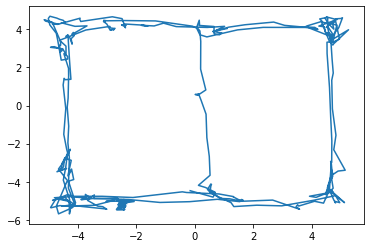

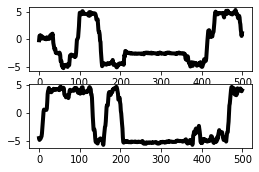

In [3]:
factor_dim = 2
Factor = np.random.randn(factor_dim,neuron_num)

NRep=1
output = np.zeros((NRep,Time,neuron_num))

for i in range(NRep):
    output[i,:,:] = y_data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)

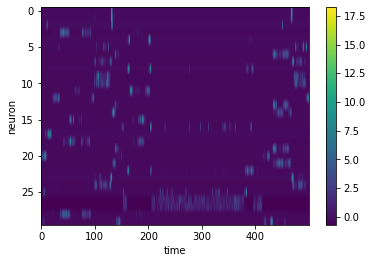

In [4]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('time')
plt.ylabel('neuron')
plt.colorbar()
plt.show()

In [5]:
# Create Tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((output))
#print(dataset)
#dataset = dataset.shuffle(20, reshuffle_each_iteration=True)

# Autoencoder Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        #self.dense_output = tf.keras.layers.Dense(64, activation='relu')
        self.dense_output2 = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        #xo = self.dense_output(x)
        xo = self.dense_output2(x)
        xo = tf.exp(xo)
        return xo, x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)[0]
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    def latent(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        latent = self.decoder(z)[1]
        return latent

In [11]:
BATCH_SIZE = 64
batched_dataset = dataset.batch(BATCH_SIZE)

In [12]:
vae = VariationalAutoEncoder(latent_dim=32,
                             num_gru_unit=32,
                             sequence_length=Time,
                             num_input_neuron=neuron_num,
                             num_factor=2)

# Train Model

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=4e-3,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [14]:
KL_penalty = np.linspace(0,1,10)

In [15]:
epochs = 6500

for i,kl_ in enumerate(KL_penalty):
    print(kl_,i)
    if i > 0:
        break
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,),'i',i)

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                #print("loss",loss,"kl",sum(vae.losses))
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:
                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))

0.0 0
Start of epoch 0 i 0
step 0: mean loss = 2.000408
Start of epoch 1 i 0
step 0: mean loss = 1.9942126
Start of epoch 2 i 0
step 0: mean loss = 1.987763
Start of epoch 3 i 0
step 0: mean loss = 1.9813025
Start of epoch 4 i 0
step 0: mean loss = 1.97459
Start of epoch 5 i 0
step 0: mean loss = 1.9674762
Start of epoch 6 i 0
step 0: mean loss = 1.9602448
Start of epoch 7 i 0
step 0: mean loss = 1.9527546
Start of epoch 8 i 0
step 0: mean loss = 1.9450016
Start of epoch 9 i 0
step 0: mean loss = 1.937205
Start of epoch 10 i 0
step 0: mean loss = 1.9293523
Start of epoch 11 i 0
step 0: mean loss = 1.9215878
Start of epoch 12 i 0
step 0: mean loss = 1.9139851
Start of epoch 13 i 0
step 0: mean loss = 1.9064189
Start of epoch 14 i 0
step 0: mean loss = 1.8988132
Start of epoch 15 i 0
step 0: mean loss = 1.8912202
Start of epoch 16 i 0
step 0: mean loss = 1.8837525
Start of epoch 17 i 0
step 0: mean loss = 1.8763235
Start of epoch 18 i 0
step 0: mean loss = 1.8689455
Start of epoch 19 i 0

step 0: mean loss = 1.2261243
Start of epoch 158 i 0
step 0: mean loss = 1.2246968
Start of epoch 159 i 0
step 0: mean loss = 1.223287
Start of epoch 160 i 0
step 0: mean loss = 1.2218944
Start of epoch 161 i 0
step 0: mean loss = 1.2205185
Start of epoch 162 i 0
step 0: mean loss = 1.2191596
Start of epoch 163 i 0
step 0: mean loss = 1.2178161
Start of epoch 164 i 0
step 0: mean loss = 1.2164886
Start of epoch 165 i 0
step 0: mean loss = 1.2151772
Start of epoch 166 i 0
step 0: mean loss = 1.2138811
Start of epoch 167 i 0
step 0: mean loss = 1.2125998
Start of epoch 168 i 0
step 0: mean loss = 1.2113327
Start of epoch 169 i 0
step 0: mean loss = 1.2100798
Start of epoch 170 i 0
step 0: mean loss = 1.2088414
Start of epoch 171 i 0
step 0: mean loss = 1.2076173
Start of epoch 172 i 0
step 0: mean loss = 1.206407
Start of epoch 173 i 0
step 0: mean loss = 1.2052107
Start of epoch 174 i 0
step 0: mean loss = 1.204028
Start of epoch 175 i 0
step 0: mean loss = 1.2028587
Start of epoch 176 

step 0: mean loss = 1.1123266
Start of epoch 313 i 0
step 0: mean loss = 1.1119479
Start of epoch 314 i 0
step 0: mean loss = 1.1115712
Start of epoch 315 i 0
step 0: mean loss = 1.1111966
Start of epoch 316 i 0
step 0: mean loss = 1.1108246
Start of epoch 317 i 0
step 0: mean loss = 1.1104542
Start of epoch 318 i 0
step 0: mean loss = 1.1100864
Start of epoch 319 i 0
step 0: mean loss = 1.1097207
Start of epoch 320 i 0
step 0: mean loss = 1.1093569
Start of epoch 321 i 0
step 0: mean loss = 1.1089954
Start of epoch 322 i 0
step 0: mean loss = 1.1086359
Start of epoch 323 i 0
step 0: mean loss = 1.1082784
Start of epoch 324 i 0
step 0: mean loss = 1.1079228
Start of epoch 325 i 0
step 0: mean loss = 1.1075691
Start of epoch 326 i 0
step 0: mean loss = 1.1072179
Start of epoch 327 i 0
step 0: mean loss = 1.1068681
Start of epoch 328 i 0
step 0: mean loss = 1.1065205
Start of epoch 329 i 0
step 0: mean loss = 1.1061747
Start of epoch 330 i 0
step 0: mean loss = 1.105831
Start of epoch 33

step 0: mean loss = 1.0691679
Start of epoch 468 i 0
step 0: mean loss = 1.068971
Start of epoch 469 i 0
step 0: mean loss = 1.0687717
Start of epoch 470 i 0
step 0: mean loss = 1.0685761
Start of epoch 471 i 0
step 0: mean loss = 1.0683789
Start of epoch 472 i 0
step 0: mean loss = 1.0681841
Start of epoch 473 i 0
step 0: mean loss = 1.0679876
Start of epoch 474 i 0
step 0: mean loss = 1.0677953
Start of epoch 475 i 0
step 0: mean loss = 1.0676006
Start of epoch 476 i 0
step 0: mean loss = 1.0674092
Start of epoch 477 i 0
step 0: mean loss = 1.0672159
Start of epoch 478 i 0
step 0: mean loss = 1.0670282
Start of epoch 479 i 0
step 0: mean loss = 1.066837
Start of epoch 480 i 0
step 0: mean loss = 1.0666481
Start of epoch 481 i 0
step 0: mean loss = 1.0664579
Start of epoch 482 i 0
step 0: mean loss = 1.0662713
Start of epoch 483 i 0
step 0: mean loss = 1.066083
Start of epoch 484 i 0
step 0: mean loss = 1.0658966
Start of epoch 485 i 0
step 0: mean loss = 1.0657091
Start of epoch 486 

step 0: mean loss = 1.0457559
Start of epoch 623 i 0
step 0: mean loss = 1.0456443
Start of epoch 624 i 0
step 0: mean loss = 1.045532
Start of epoch 625 i 0
step 0: mean loss = 1.0454212
Start of epoch 626 i 0
step 0: mean loss = 1.0453103
Start of epoch 627 i 0
step 0: mean loss = 1.0451978
Start of epoch 628 i 0
step 0: mean loss = 1.0450865
Start of epoch 629 i 0
step 0: mean loss = 1.0449752
Start of epoch 630 i 0
step 0: mean loss = 1.0448631
Start of epoch 631 i 0
step 0: mean loss = 1.0447518
Start of epoch 632 i 0
step 0: mean loss = 1.0446398
Start of epoch 633 i 0
step 0: mean loss = 1.0445288
Start of epoch 634 i 0
step 0: mean loss = 1.0444171
Start of epoch 635 i 0
step 0: mean loss = 1.0443064
Start of epoch 636 i 0
step 0: mean loss = 1.0441946
Start of epoch 637 i 0
step 0: mean loss = 1.0440835
Start of epoch 638 i 0
step 0: mean loss = 1.0439724
Start of epoch 639 i 0
step 0: mean loss = 1.0438615
Start of epoch 640 i 0
step 0: mean loss = 1.0437504
Start of epoch 64

step 0: mean loss = 1.030784
Start of epoch 778 i 0
step 0: mean loss = 1.0306951
Start of epoch 779 i 0
step 0: mean loss = 1.0306065
Start of epoch 780 i 0
step 0: mean loss = 1.0305179
Start of epoch 781 i 0
step 0: mean loss = 1.0304296
Start of epoch 782 i 0
step 0: mean loss = 1.0303414
Start of epoch 783 i 0
step 0: mean loss = 1.0302534
Start of epoch 784 i 0
step 0: mean loss = 1.0301654
Start of epoch 785 i 0
step 0: mean loss = 1.0300777
Start of epoch 786 i 0
step 0: mean loss = 1.0299901
Start of epoch 787 i 0
step 0: mean loss = 1.0299026
Start of epoch 788 i 0
step 0: mean loss = 1.0298152
Start of epoch 789 i 0
step 0: mean loss = 1.0297282
Start of epoch 790 i 0
step 0: mean loss = 1.0296413
Start of epoch 791 i 0
step 0: mean loss = 1.0295546
Start of epoch 792 i 0
step 0: mean loss = 1.0294679
Start of epoch 793 i 0
step 0: mean loss = 1.0293815
Start of epoch 794 i 0
step 0: mean loss = 1.0292953
Start of epoch 795 i 0
step 0: mean loss = 1.0292093
Start of epoch 79

step 0: mean loss = 1.0189681
Start of epoch 933 i 0
step 0: mean loss = 1.0189139
Start of epoch 934 i 0
step 0: mean loss = 1.0188522
Start of epoch 935 i 0
step 0: mean loss = 1.0187882
Start of epoch 936 i 0
step 0: mean loss = 1.0187258
Start of epoch 937 i 0
step 0: mean loss = 1.018663
Start of epoch 938 i 0
step 0: mean loss = 1.0185997
Start of epoch 939 i 0
step 0: mean loss = 1.0185366
Start of epoch 940 i 0
step 0: mean loss = 1.0184739
Start of epoch 941 i 0
step 0: mean loss = 1.0184102
Start of epoch 942 i 0
step 0: mean loss = 1.0183471
Start of epoch 943 i 0
step 0: mean loss = 1.018284
Start of epoch 944 i 0
step 0: mean loss = 1.0182219
Start of epoch 945 i 0
step 0: mean loss = 1.0181614
Start of epoch 946 i 0
step 0: mean loss = 1.0180982
Start of epoch 947 i 0
step 0: mean loss = 1.0180349
Start of epoch 948 i 0
step 0: mean loss = 1.0179806
Start of epoch 949 i 0
step 0: mean loss = 1.0179183
Start of epoch 950 i 0
step 0: mean loss = 1.0178593
Start of epoch 951

step 0: mean loss = 1.010449
Start of epoch 1087 i 0
step 0: mean loss = 1.0103978
Start of epoch 1088 i 0
step 0: mean loss = 1.010351
Start of epoch 1089 i 0
step 0: mean loss = 1.0103182
Start of epoch 1090 i 0
step 0: mean loss = 1.0102884
Start of epoch 1091 i 0
step 0: mean loss = 1.0102618
Start of epoch 1092 i 0
step 0: mean loss = 1.0102366
Start of epoch 1093 i 0
step 0: mean loss = 1.0102087
Start of epoch 1094 i 0
step 0: mean loss = 1.0101792
Start of epoch 1095 i 0
step 0: mean loss = 1.0101422
Start of epoch 1096 i 0
step 0: mean loss = 1.0101149
Start of epoch 1097 i 0
step 0: mean loss = 1.0100825
Start of epoch 1098 i 0
step 0: mean loss = 1.010054
Start of epoch 1099 i 0
step 0: mean loss = 1.0100318
Start of epoch 1100 i 0
step 0: mean loss = 1.010009
Start of epoch 1101 i 0
step 0: mean loss = 1.0099845
Start of epoch 1102 i 0
step 0: mean loss = 1.0099579
Start of epoch 1103 i 0
step 0: mean loss = 1.009928
Start of epoch 1104 i 0
step 0: mean loss = 1.0098914
Sta

step 0: mean loss = 1.0078048
Start of epoch 1240 i 0
step 0: mean loss = 1.0077984
Start of epoch 1241 i 0
step 0: mean loss = 1.0077921
Start of epoch 1242 i 0
step 0: mean loss = 1.0077859
Start of epoch 1243 i 0
step 0: mean loss = 1.0077796
Start of epoch 1244 i 0
step 0: mean loss = 1.0077734
Start of epoch 1245 i 0
step 0: mean loss = 1.0077671
Start of epoch 1246 i 0
step 0: mean loss = 1.0077609
Start of epoch 1247 i 0
step 0: mean loss = 1.0077547
Start of epoch 1248 i 0
step 0: mean loss = 1.0077485
Start of epoch 1249 i 0
step 0: mean loss = 1.0077423
Start of epoch 1250 i 0
step 0: mean loss = 1.0077361
Start of epoch 1251 i 0
step 0: mean loss = 1.0077299
Start of epoch 1252 i 0
step 0: mean loss = 1.0077237
Start of epoch 1253 i 0
step 0: mean loss = 1.0077176
Start of epoch 1254 i 0
step 0: mean loss = 1.0077114
Start of epoch 1255 i 0
step 0: mean loss = 1.0077053
Start of epoch 1256 i 0
step 0: mean loss = 1.0076991
Start of epoch 1257 i 0
step 0: mean loss = 1.007693

step 0: mean loss = 1.0069475
Start of epoch 1393 i 0
step 0: mean loss = 1.0069425
Start of epoch 1394 i 0
step 0: mean loss = 1.0069375
Start of epoch 1395 i 0
step 0: mean loss = 1.0069326
Start of epoch 1396 i 0
step 0: mean loss = 1.0069276
Start of epoch 1397 i 0
step 0: mean loss = 1.0069226
Start of epoch 1398 i 0
step 0: mean loss = 1.0069177
Start of epoch 1399 i 0
step 0: mean loss = 1.0069127
Start of epoch 1400 i 0
step 0: mean loss = 1.0069078
Start of epoch 1401 i 0
step 0: mean loss = 1.0069029
Start of epoch 1402 i 0
step 0: mean loss = 1.0068979
Start of epoch 1403 i 0
step 0: mean loss = 1.006893
Start of epoch 1404 i 0
step 0: mean loss = 1.0068882
Start of epoch 1405 i 0
step 0: mean loss = 1.0068833
Start of epoch 1406 i 0
step 0: mean loss = 1.0068784
Start of epoch 1407 i 0
step 0: mean loss = 1.0068735
Start of epoch 1408 i 0
step 0: mean loss = 1.0068686
Start of epoch 1409 i 0
step 0: mean loss = 1.0068637
Start of epoch 1410 i 0
step 0: mean loss = 1.0068588

step 0: mean loss = 1.006264
Start of epoch 1545 i 0
step 0: mean loss = 1.0062599
Start of epoch 1546 i 0
step 0: mean loss = 1.0062559
Start of epoch 1547 i 0
step 0: mean loss = 1.0062518
Start of epoch 1548 i 0
step 0: mean loss = 1.0062478
Start of epoch 1549 i 0
step 0: mean loss = 1.0062438
Start of epoch 1550 i 0
step 0: mean loss = 1.0062398
Start of epoch 1551 i 0
step 0: mean loss = 1.0062357
Start of epoch 1552 i 0
step 0: mean loss = 1.0062317
Start of epoch 1553 i 0
step 0: mean loss = 1.0062277
Start of epoch 1554 i 0
step 0: mean loss = 1.0062237
Start of epoch 1555 i 0
step 0: mean loss = 1.0062197
Start of epoch 1556 i 0
step 0: mean loss = 1.0062157
Start of epoch 1557 i 0
step 0: mean loss = 1.0062118
Start of epoch 1558 i 0
step 0: mean loss = 1.0062077
Start of epoch 1559 i 0
step 0: mean loss = 1.0062038
Start of epoch 1560 i 0
step 0: mean loss = 1.0061998
Start of epoch 1561 i 0
step 0: mean loss = 1.0061958
Start of epoch 1562 i 0
step 0: mean loss = 1.0061918

step 0: mean loss = 1.0056995
Start of epoch 1698 i 0
step 0: mean loss = 1.0056962
Start of epoch 1699 i 0
step 0: mean loss = 1.0056928
Start of epoch 1700 i 0
step 0: mean loss = 1.0056895
Start of epoch 1701 i 0
step 0: mean loss = 1.0056862
Start of epoch 1702 i 0
step 0: mean loss = 1.0056828
Start of epoch 1703 i 0
step 0: mean loss = 1.0056795
Start of epoch 1704 i 0
step 0: mean loss = 1.0056762
Start of epoch 1705 i 0
step 0: mean loss = 1.0056728
Start of epoch 1706 i 0
step 0: mean loss = 1.0056695
Start of epoch 1707 i 0
step 0: mean loss = 1.0056661
Start of epoch 1708 i 0
step 0: mean loss = 1.0056629
Start of epoch 1709 i 0
step 0: mean loss = 1.0056596
Start of epoch 1710 i 0
step 0: mean loss = 1.0056562
Start of epoch 1711 i 0
step 0: mean loss = 1.0056529
Start of epoch 1712 i 0
step 0: mean loss = 1.0056497
Start of epoch 1713 i 0
step 0: mean loss = 1.0056463
Start of epoch 1714 i 0
step 0: mean loss = 1.005643
Start of epoch 1715 i 0
step 0: mean loss = 1.0056398

step 0: mean loss = 1.0052284
Start of epoch 1851 i 0
step 0: mean loss = 1.0052257
Start of epoch 1852 i 0
step 0: mean loss = 1.0052228
Start of epoch 1853 i 0
step 0: mean loss = 1.0052199
Start of epoch 1854 i 0
step 0: mean loss = 1.0052172
Start of epoch 1855 i 0
step 0: mean loss = 1.0052143
Start of epoch 1856 i 0
step 0: mean loss = 1.0052116
Start of epoch 1857 i 0
step 0: mean loss = 1.0052087
Start of epoch 1858 i 0
step 0: mean loss = 1.005206
Start of epoch 1859 i 0
step 0: mean loss = 1.0052031
Start of epoch 1860 i 0
step 0: mean loss = 1.0052004
Start of epoch 1861 i 0
step 0: mean loss = 1.0051975
Start of epoch 1862 i 0
step 0: mean loss = 1.0051948
Start of epoch 1863 i 0
step 0: mean loss = 1.005192
Start of epoch 1864 i 0
step 0: mean loss = 1.0051892
Start of epoch 1865 i 0
step 0: mean loss = 1.0051864
Start of epoch 1866 i 0
step 0: mean loss = 1.0051837
Start of epoch 1867 i 0
step 0: mean loss = 1.0051808
Start of epoch 1868 i 0
step 0: mean loss = 1.0051781


step 0: mean loss = 1.0048293
Start of epoch 2004 i 0
step 0: mean loss = 1.0048269
Start of epoch 2005 i 0
step 0: mean loss = 1.0048244
Start of epoch 2006 i 0
step 0: mean loss = 1.004822
Start of epoch 2007 i 0
step 0: mean loss = 1.0048196
Start of epoch 2008 i 0
step 0: mean loss = 1.0048172
Start of epoch 2009 i 0
step 0: mean loss = 1.0048149
Start of epoch 2010 i 0
step 0: mean loss = 1.0048125
Start of epoch 2011 i 0
step 0: mean loss = 1.0048101
Start of epoch 2012 i 0
step 0: mean loss = 1.0048077
Start of epoch 2013 i 0
step 0: mean loss = 1.0048053
Start of epoch 2014 i 0
step 0: mean loss = 1.004803
Start of epoch 2015 i 0
step 0: mean loss = 1.0048006
Start of epoch 2016 i 0
step 0: mean loss = 1.0047982
Start of epoch 2017 i 0
step 0: mean loss = 1.0047958
Start of epoch 2018 i 0
step 0: mean loss = 1.0047934
Start of epoch 2019 i 0
step 0: mean loss = 1.004791
Start of epoch 2020 i 0
step 0: mean loss = 1.0047886
Start of epoch 2021 i 0
step 0: mean loss = 1.0047863
S

step 0: mean loss = 1.0044868
Start of epoch 2157 i 0
step 0: mean loss = 1.0044847
Start of epoch 2158 i 0
step 0: mean loss = 1.0044826
Start of epoch 2159 i 0
step 0: mean loss = 1.0044806
Start of epoch 2160 i 0
step 0: mean loss = 1.0044785
Start of epoch 2161 i 0
step 0: mean loss = 1.0044764
Start of epoch 2162 i 0
step 0: mean loss = 1.0044743
Start of epoch 2163 i 0
step 0: mean loss = 1.0044723
Start of epoch 2164 i 0
step 0: mean loss = 1.0044702
Start of epoch 2165 i 0
step 0: mean loss = 1.0044681
Start of epoch 2166 i 0
step 0: mean loss = 1.004466
Start of epoch 2167 i 0
step 0: mean loss = 1.004464
Start of epoch 2168 i 0
step 0: mean loss = 1.004462
Start of epoch 2169 i 0
step 0: mean loss = 1.0044599
Start of epoch 2170 i 0
step 0: mean loss = 1.0044578
Start of epoch 2171 i 0
step 0: mean loss = 1.0044558
Start of epoch 2172 i 0
step 0: mean loss = 1.0044538
Start of epoch 2173 i 0
step 0: mean loss = 1.0044516
Start of epoch 2174 i 0
step 0: mean loss = 1.0044496
S

step 0: mean loss = 1.0041914
Start of epoch 2309 i 0
step 0: mean loss = 1.0041896
Start of epoch 2310 i 0
step 0: mean loss = 1.0041878
Start of epoch 2311 i 0
step 0: mean loss = 1.004186
Start of epoch 2312 i 0
step 0: mean loss = 1.0041841
Start of epoch 2313 i 0
step 0: mean loss = 1.0041823
Start of epoch 2314 i 0
step 0: mean loss = 1.0041806
Start of epoch 2315 i 0
step 0: mean loss = 1.0041788
Start of epoch 2316 i 0
step 0: mean loss = 1.004177
Start of epoch 2317 i 0
step 0: mean loss = 1.0041752
Start of epoch 2318 i 0
step 0: mean loss = 1.0041734
Start of epoch 2319 i 0
step 0: mean loss = 1.0041715
Start of epoch 2320 i 0
step 0: mean loss = 1.0041697
Start of epoch 2321 i 0
step 0: mean loss = 1.0041679
Start of epoch 2322 i 0
step 0: mean loss = 1.0041661
Start of epoch 2323 i 0
step 0: mean loss = 1.0041643
Start of epoch 2324 i 0
step 0: mean loss = 1.0041625
Start of epoch 2325 i 0
step 0: mean loss = 1.0041608
Start of epoch 2326 i 0
step 0: mean loss = 1.004159
S

step 0: mean loss = 1.0039309
Start of epoch 2462 i 0
step 0: mean loss = 1.0039294
Start of epoch 2463 i 0
step 0: mean loss = 1.0039277
Start of epoch 2464 i 0
step 0: mean loss = 1.0039262
Start of epoch 2465 i 0
step 0: mean loss = 1.0039246
Start of epoch 2466 i 0
step 0: mean loss = 1.0039229
Start of epoch 2467 i 0
step 0: mean loss = 1.0039214
Start of epoch 2468 i 0
step 0: mean loss = 1.0039198
Start of epoch 2469 i 0
step 0: mean loss = 1.0039182
Start of epoch 2470 i 0
step 0: mean loss = 1.0039166
Start of epoch 2471 i 0
step 0: mean loss = 1.0039151
Start of epoch 2472 i 0
step 0: mean loss = 1.0039134
Start of epoch 2473 i 0
step 0: mean loss = 1.0039119
Start of epoch 2474 i 0
step 0: mean loss = 1.0039103
Start of epoch 2475 i 0
step 0: mean loss = 1.0039088
Start of epoch 2476 i 0
step 0: mean loss = 1.0039071
Start of epoch 2477 i 0
step 0: mean loss = 1.0039055
Start of epoch 2478 i 0
step 0: mean loss = 1.003904
Start of epoch 2479 i 0
step 0: mean loss = 1.0039024

step 0: mean loss = 1.0037024
Start of epoch 2614 i 0
step 0: mean loss = 1.003701
Start of epoch 2615 i 0
step 0: mean loss = 1.0036995
Start of epoch 2616 i 0
step 0: mean loss = 1.0036981
Start of epoch 2617 i 0
step 0: mean loss = 1.0036967
Start of epoch 2618 i 0
step 0: mean loss = 1.0036952
Start of epoch 2619 i 0
step 0: mean loss = 1.0036939
Start of epoch 2620 i 0
step 0: mean loss = 1.0036925
Start of epoch 2621 i 0
step 0: mean loss = 1.0036911
Start of epoch 2622 i 0
step 0: mean loss = 1.0036896
Start of epoch 2623 i 0
step 0: mean loss = 1.0036882
Start of epoch 2624 i 0
step 0: mean loss = 1.0036869
Start of epoch 2625 i 0
step 0: mean loss = 1.0036855
Start of epoch 2626 i 0
step 0: mean loss = 1.003684
Start of epoch 2627 i 0
step 0: mean loss = 1.0036826
Start of epoch 2628 i 0
step 0: mean loss = 1.0036812
Start of epoch 2629 i 0
step 0: mean loss = 1.0036799
Start of epoch 2630 i 0
step 0: mean loss = 1.0036784
Start of epoch 2631 i 0
step 0: mean loss = 1.003677
S

step 0: mean loss = 1.0034989
Start of epoch 2766 i 0
step 0: mean loss = 1.0034976
Start of epoch 2767 i 0
step 0: mean loss = 1.0034964
Start of epoch 2768 i 0
step 0: mean loss = 1.0034951
Start of epoch 2769 i 0
step 0: mean loss = 1.0034939
Start of epoch 2770 i 0
step 0: mean loss = 1.0034926
Start of epoch 2771 i 0
step 0: mean loss = 1.0034913
Start of epoch 2772 i 0
step 0: mean loss = 1.0034901
Start of epoch 2773 i 0
step 0: mean loss = 1.0034888
Start of epoch 2774 i 0
step 0: mean loss = 1.0034876
Start of epoch 2775 i 0
step 0: mean loss = 1.0034863
Start of epoch 2776 i 0
step 0: mean loss = 1.0034851
Start of epoch 2777 i 0
step 0: mean loss = 1.0034838
Start of epoch 2778 i 0
step 0: mean loss = 1.0034826
Start of epoch 2779 i 0
step 0: mean loss = 1.0034813
Start of epoch 2780 i 0
step 0: mean loss = 1.0034801
Start of epoch 2781 i 0
step 0: mean loss = 1.0034788
Start of epoch 2782 i 0
step 0: mean loss = 1.0034776
Start of epoch 2783 i 0
step 0: mean loss = 1.003476

step 0: mean loss = 1.0033166
Start of epoch 2918 i 0
step 0: mean loss = 1.0033156
Start of epoch 2919 i 0
step 0: mean loss = 1.0033144
Start of epoch 2920 i 0
step 0: mean loss = 1.0033132
Start of epoch 2921 i 0
step 0: mean loss = 1.0033121
Start of epoch 2922 i 0
step 0: mean loss = 1.0033109
Start of epoch 2923 i 0
step 0: mean loss = 1.0033098
Start of epoch 2924 i 0
step 0: mean loss = 1.0033087
Start of epoch 2925 i 0
step 0: mean loss = 1.0033076
Start of epoch 2926 i 0
step 0: mean loss = 1.0033065
Start of epoch 2927 i 0
step 0: mean loss = 1.0033053
Start of epoch 2928 i 0
step 0: mean loss = 1.0033042
Start of epoch 2929 i 0
step 0: mean loss = 1.003303
Start of epoch 2930 i 0
step 0: mean loss = 1.003302
Start of epoch 2931 i 0
step 0: mean loss = 1.0033008
Start of epoch 2932 i 0
step 0: mean loss = 1.0032997
Start of epoch 2933 i 0
step 0: mean loss = 1.0032985
Start of epoch 2934 i 0
step 0: mean loss = 1.0032974
Start of epoch 2935 i 0
step 0: mean loss = 1.0032963


step 0: mean loss = 1.0031514
Start of epoch 3071 i 0
step 0: mean loss = 1.0031503
Start of epoch 3072 i 0
step 0: mean loss = 1.0031494
Start of epoch 3073 i 0
step 0: mean loss = 1.0031483
Start of epoch 3074 i 0
step 0: mean loss = 1.0031474
Start of epoch 3075 i 0
step 0: mean loss = 1.0031463
Start of epoch 3076 i 0
step 0: mean loss = 1.0031452
Start of epoch 3077 i 0
step 0: mean loss = 1.0031443
Start of epoch 3078 i 0
step 0: mean loss = 1.0031432
Start of epoch 3079 i 0
step 0: mean loss = 1.0031422
Start of epoch 3080 i 0
step 0: mean loss = 1.0031412
Start of epoch 3081 i 0
step 0: mean loss = 1.0031402
Start of epoch 3082 i 0
step 0: mean loss = 1.0031391
Start of epoch 3083 i 0
step 0: mean loss = 1.0031382
Start of epoch 3084 i 0
step 0: mean loss = 1.0031371
Start of epoch 3085 i 0
step 0: mean loss = 1.003136
Start of epoch 3086 i 0
step 0: mean loss = 1.0031351
Start of epoch 3087 i 0
step 0: mean loss = 1.003134
Start of epoch 3088 i 0
step 0: mean loss = 1.003133
S

step 0: mean loss = 1.0030018
Start of epoch 3224 i 0
step 0: mean loss = 1.003001
Start of epoch 3225 i 0
step 0: mean loss = 1.003
Start of epoch 3226 i 0
step 0: mean loss = 1.0029991
Start of epoch 3227 i 0
step 0: mean loss = 1.0029981
Start of epoch 3228 i 0
step 0: mean loss = 1.0029972
Start of epoch 3229 i 0
step 0: mean loss = 1.0029963
Start of epoch 3230 i 0
step 0: mean loss = 1.0029954
Start of epoch 3231 i 0
step 0: mean loss = 1.0029944
Start of epoch 3232 i 0
step 0: mean loss = 1.0029935
Start of epoch 3233 i 0
step 0: mean loss = 1.0029926
Start of epoch 3234 i 0
step 0: mean loss = 1.0029917
Start of epoch 3235 i 0
step 0: mean loss = 1.0029907
Start of epoch 3236 i 0
step 0: mean loss = 1.0029898
Start of epoch 3237 i 0
step 0: mean loss = 1.0029889
Start of epoch 3238 i 0
step 0: mean loss = 1.002988
Start of epoch 3239 i 0
step 0: mean loss = 1.002987
Start of epoch 3240 i 0
step 0: mean loss = 1.0029861
Start of epoch 3241 i 0
step 0: mean loss = 1.0029852
Start

step 0: mean loss = 1.0028658
Start of epoch 3377 i 0
step 0: mean loss = 1.002865
Start of epoch 3378 i 0
step 0: mean loss = 1.0028641
Start of epoch 3379 i 0
step 0: mean loss = 1.0028633
Start of epoch 3380 i 0
step 0: mean loss = 1.0028625
Start of epoch 3381 i 0
step 0: mean loss = 1.0028616
Start of epoch 3382 i 0
step 0: mean loss = 1.0028608
Start of epoch 3383 i 0
step 0: mean loss = 1.00286
Start of epoch 3384 i 0
step 0: mean loss = 1.0028591
Start of epoch 3385 i 0
step 0: mean loss = 1.0028583
Start of epoch 3386 i 0
step 0: mean loss = 1.0028574
Start of epoch 3387 i 0
step 0: mean loss = 1.0028565
Start of epoch 3388 i 0
step 0: mean loss = 1.0028557
Start of epoch 3389 i 0
step 0: mean loss = 1.0028548
Start of epoch 3390 i 0
step 0: mean loss = 1.002854
Start of epoch 3391 i 0
step 0: mean loss = 1.0028532
Start of epoch 3392 i 0
step 0: mean loss = 1.0028523
Start of epoch 3393 i 0
step 0: mean loss = 1.0028515
Start of epoch 3394 i 0
step 0: mean loss = 1.0028507
St

step 0: mean loss = 1.0027417
Start of epoch 3530 i 0
step 0: mean loss = 1.0027409
Start of epoch 3531 i 0
step 0: mean loss = 1.00274
Start of epoch 3532 i 0
step 0: mean loss = 1.0027393
Start of epoch 3533 i 0
step 0: mean loss = 1.0027385
Start of epoch 3534 i 0
step 0: mean loss = 1.0027378
Start of epoch 3535 i 0
step 0: mean loss = 1.0027369
Start of epoch 3536 i 0
step 0: mean loss = 1.0027362
Start of epoch 3537 i 0
step 0: mean loss = 1.0027355
Start of epoch 3538 i 0
step 0: mean loss = 1.0027347
Start of epoch 3539 i 0
step 0: mean loss = 1.002734
Start of epoch 3540 i 0
step 0: mean loss = 1.0027331
Start of epoch 3541 i 0
step 0: mean loss = 1.0027324
Start of epoch 3542 i 0
step 0: mean loss = 1.0027316
Start of epoch 3543 i 0
step 0: mean loss = 1.0027308
Start of epoch 3544 i 0
step 0: mean loss = 1.00273
Start of epoch 3545 i 0
step 0: mean loss = 1.0027293
Start of epoch 3546 i 0
step 0: mean loss = 1.0027285
Start of epoch 3547 i 0
step 0: mean loss = 1.0027277
Sta

step 0: mean loss = 1.0026277
Start of epoch 3683 i 0
step 0: mean loss = 1.002627
Start of epoch 3684 i 0
step 0: mean loss = 1.0026263
Start of epoch 3685 i 0
step 0: mean loss = 1.0026256
Start of epoch 3686 i 0
step 0: mean loss = 1.0026249
Start of epoch 3687 i 0
step 0: mean loss = 1.0026242
Start of epoch 3688 i 0
step 0: mean loss = 1.0026234
Start of epoch 3689 i 0
step 0: mean loss = 1.0026227
Start of epoch 3690 i 0
step 0: mean loss = 1.002622
Start of epoch 3691 i 0
step 0: mean loss = 1.0026213
Start of epoch 3692 i 0
step 0: mean loss = 1.0026206
Start of epoch 3693 i 0
step 0: mean loss = 1.0026199
Start of epoch 3694 i 0
step 0: mean loss = 1.0026193
Start of epoch 3695 i 0
step 0: mean loss = 1.0026186
Start of epoch 3696 i 0
step 0: mean loss = 1.0026178
Start of epoch 3697 i 0
step 0: mean loss = 1.0026171
Start of epoch 3698 i 0
step 0: mean loss = 1.0026164
Start of epoch 3699 i 0
step 0: mean loss = 1.0026157
Start of epoch 3700 i 0
step 0: mean loss = 1.002615
S

step 0: mean loss = 1.002523
Start of epoch 3836 i 0
step 0: mean loss = 1.0025222
Start of epoch 3837 i 0
step 0: mean loss = 1.0025216
Start of epoch 3838 i 0
step 0: mean loss = 1.0025209
Start of epoch 3839 i 0
step 0: mean loss = 1.0025203
Start of epoch 3840 i 0
step 0: mean loss = 1.0025196
Start of epoch 3841 i 0
step 0: mean loss = 1.002519
Start of epoch 3842 i 0
step 0: mean loss = 1.0025183
Start of epoch 3843 i 0
step 0: mean loss = 1.0025177
Start of epoch 3844 i 0
step 0: mean loss = 1.002517
Start of epoch 3845 i 0
step 0: mean loss = 1.0025164
Start of epoch 3846 i 0
step 0: mean loss = 1.0025157
Start of epoch 3847 i 0
step 0: mean loss = 1.0025151
Start of epoch 3848 i 0
step 0: mean loss = 1.0025144
Start of epoch 3849 i 0
step 0: mean loss = 1.0025138
Start of epoch 3850 i 0
step 0: mean loss = 1.002513
Start of epoch 3851 i 0
step 0: mean loss = 1.0025125
Start of epoch 3852 i 0
step 0: mean loss = 1.0025119
Start of epoch 3853 i 0
step 0: mean loss = 1.0025111
St

step 0: mean loss = 1.0024261
Start of epoch 3989 i 0
step 0: mean loss = 1.0024256
Start of epoch 3990 i 0
step 0: mean loss = 1.002425
Start of epoch 3991 i 0
step 0: mean loss = 1.0024244
Start of epoch 3992 i 0
step 0: mean loss = 1.0024238
Start of epoch 3993 i 0
step 0: mean loss = 1.0024232
Start of epoch 3994 i 0
step 0: mean loss = 1.0024226
Start of epoch 3995 i 0
step 0: mean loss = 1.002422
Start of epoch 3996 i 0
step 0: mean loss = 1.0024213
Start of epoch 3997 i 0
step 0: mean loss = 1.0024207
Start of epoch 3998 i 0
step 0: mean loss = 1.0024201
Start of epoch 3999 i 0
step 0: mean loss = 1.0024195
Start of epoch 4000 i 0
step 0: mean loss = 1.0024189
Start of epoch 4001 i 0
step 0: mean loss = 1.0024183
Start of epoch 4002 i 0
step 0: mean loss = 1.0024177
Start of epoch 4003 i 0
step 0: mean loss = 1.0024171
Start of epoch 4004 i 0
step 0: mean loss = 1.0024165
Start of epoch 4005 i 0
step 0: mean loss = 1.0024159
Start of epoch 4006 i 0
step 0: mean loss = 1.0024153


step 0: mean loss = 1.0023372
Start of epoch 4141 i 0
step 0: mean loss = 1.0023366
Start of epoch 4142 i 0
step 0: mean loss = 1.002336
Start of epoch 4143 i 0
step 0: mean loss = 1.0023354
Start of epoch 4144 i 0
step 0: mean loss = 1.002335
Start of epoch 4145 i 0
step 0: mean loss = 1.0023344
Start of epoch 4146 i 0
step 0: mean loss = 1.0023338
Start of epoch 4147 i 0
step 0: mean loss = 1.0023333
Start of epoch 4148 i 0
step 0: mean loss = 1.0023327
Start of epoch 4149 i 0
step 0: mean loss = 1.0023321
Start of epoch 4150 i 0
step 0: mean loss = 1.0023315
Start of epoch 4151 i 0
step 0: mean loss = 1.002331
Start of epoch 4152 i 0
step 0: mean loss = 1.0023304
Start of epoch 4153 i 0
step 0: mean loss = 1.0023298
Start of epoch 4154 i 0
step 0: mean loss = 1.0023293
Start of epoch 4155 i 0
step 0: mean loss = 1.0023288
Start of epoch 4156 i 0
step 0: mean loss = 1.0023282
Start of epoch 4157 i 0
step 0: mean loss = 1.0023276
Start of epoch 4158 i 0
step 0: mean loss = 1.0023271
S

step 0: mean loss = 1.0022539
Start of epoch 4294 i 0
step 0: mean loss = 1.0022534
Start of epoch 4295 i 0
step 0: mean loss = 1.0022528
Start of epoch 4296 i 0
step 0: mean loss = 1.0022523
Start of epoch 4297 i 0
step 0: mean loss = 1.0022517
Start of epoch 4298 i 0
step 0: mean loss = 1.0022513
Start of epoch 4299 i 0
step 0: mean loss = 1.0022508
Start of epoch 4300 i 0
step 0: mean loss = 1.0022502
Start of epoch 4301 i 0
step 0: mean loss = 1.0022497
Start of epoch 4302 i 0
step 0: mean loss = 1.0022491
Start of epoch 4303 i 0
step 0: mean loss = 1.0022486
Start of epoch 4304 i 0
step 0: mean loss = 1.0022482
Start of epoch 4305 i 0
step 0: mean loss = 1.0022476
Start of epoch 4306 i 0
step 0: mean loss = 1.0022471
Start of epoch 4307 i 0
step 0: mean loss = 1.0022466
Start of epoch 4308 i 0
step 0: mean loss = 1.002246
Start of epoch 4309 i 0
step 0: mean loss = 1.0022455
Start of epoch 4310 i 0
step 0: mean loss = 1.002245
Start of epoch 4311 i 0
step 0: mean loss = 1.0022445


step 0: mean loss = 1.0021769
Start of epoch 4446 i 0
step 0: mean loss = 1.0021764
Start of epoch 4447 i 0
step 0: mean loss = 1.0021758
Start of epoch 4448 i 0
step 0: mean loss = 1.0021753
Start of epoch 4449 i 0
step 0: mean loss = 1.0021749
Start of epoch 4450 i 0
step 0: mean loss = 1.0021744
Start of epoch 4451 i 0
step 0: mean loss = 1.0021739
Start of epoch 4452 i 0
step 0: mean loss = 1.0021734
Start of epoch 4453 i 0
step 0: mean loss = 1.002173
Start of epoch 4454 i 0
step 0: mean loss = 1.0021725
Start of epoch 4455 i 0
step 0: mean loss = 1.002172
Start of epoch 4456 i 0
step 0: mean loss = 1.0021715
Start of epoch 4457 i 0
step 0: mean loss = 1.0021709
Start of epoch 4458 i 0
step 0: mean loss = 1.0021704
Start of epoch 4459 i 0
step 0: mean loss = 1.00217
Start of epoch 4460 i 0
step 0: mean loss = 1.0021695
Start of epoch 4461 i 0
step 0: mean loss = 1.002169
Start of epoch 4462 i 0
step 0: mean loss = 1.0021685
Start of epoch 4463 i 0
step 0: mean loss = 1.002168
Star

step 0: mean loss = 1.0021044
Start of epoch 4599 i 0
step 0: mean loss = 1.0021039
Start of epoch 4600 i 0
step 0: mean loss = 1.0021034
Start of epoch 4601 i 0
step 0: mean loss = 1.0021031
Start of epoch 4602 i 0
step 0: mean loss = 1.0021026
Start of epoch 4603 i 0
step 0: mean loss = 1.0021021
Start of epoch 4604 i 0
step 0: mean loss = 1.0021017
Start of epoch 4605 i 0
step 0: mean loss = 1.0021012
Start of epoch 4606 i 0
step 0: mean loss = 1.0021007
Start of epoch 4607 i 0
step 0: mean loss = 1.0021003
Start of epoch 4608 i 0
step 0: mean loss = 1.0020999
Start of epoch 4609 i 0
step 0: mean loss = 1.0020994
Start of epoch 4610 i 0
step 0: mean loss = 1.0020989
Start of epoch 4611 i 0
step 0: mean loss = 1.0020984
Start of epoch 4612 i 0
step 0: mean loss = 1.0020981
Start of epoch 4613 i 0
step 0: mean loss = 1.0020976
Start of epoch 4614 i 0
step 0: mean loss = 1.0020971
Start of epoch 4615 i 0
step 0: mean loss = 1.0020967
Start of epoch 4616 i 0
step 0: mean loss = 1.002096

step 0: mean loss = 1.0020367
Start of epoch 4752 i 0
step 0: mean loss = 1.0020362
Start of epoch 4753 i 0
step 0: mean loss = 1.0020359
Start of epoch 4754 i 0
step 0: mean loss = 1.0020354
Start of epoch 4755 i 0
step 0: mean loss = 1.0020349
Start of epoch 4756 i 0
step 0: mean loss = 1.0020345
Start of epoch 4757 i 0
step 0: mean loss = 1.0020341
Start of epoch 4758 i 0
step 0: mean loss = 1.0020337
Start of epoch 4759 i 0
step 0: mean loss = 1.0020332
Start of epoch 4760 i 0
step 0: mean loss = 1.0020328
Start of epoch 4761 i 0
step 0: mean loss = 1.0020324
Start of epoch 4762 i 0
step 0: mean loss = 1.0020319
Start of epoch 4763 i 0
step 0: mean loss = 1.0020316
Start of epoch 4764 i 0
step 0: mean loss = 1.0020311
Start of epoch 4765 i 0
step 0: mean loss = 1.0020307
Start of epoch 4766 i 0
step 0: mean loss = 1.0020303
Start of epoch 4767 i 0
step 0: mean loss = 1.0020298
Start of epoch 4768 i 0
step 0: mean loss = 1.0020294
Start of epoch 4769 i 0
step 0: mean loss = 1.002029

step 0: mean loss = 1.0019732
Start of epoch 4905 i 0
step 0: mean loss = 1.0019727
Start of epoch 4906 i 0
step 0: mean loss = 1.0019723
Start of epoch 4907 i 0
step 0: mean loss = 1.001972
Start of epoch 4908 i 0
step 0: mean loss = 1.0019715
Start of epoch 4909 i 0
step 0: mean loss = 1.0019711
Start of epoch 4910 i 0
step 0: mean loss = 1.0019708
Start of epoch 4911 i 0
step 0: mean loss = 1.0019703
Start of epoch 4912 i 0
step 0: mean loss = 1.0019699
Start of epoch 4913 i 0
step 0: mean loss = 1.0019696
Start of epoch 4914 i 0
step 0: mean loss = 1.0019691
Start of epoch 4915 i 0
step 0: mean loss = 1.0019687
Start of epoch 4916 i 0
step 0: mean loss = 1.0019683
Start of epoch 4917 i 0
step 0: mean loss = 1.0019679
Start of epoch 4918 i 0
step 0: mean loss = 1.0019675
Start of epoch 4919 i 0
step 0: mean loss = 1.0019671
Start of epoch 4920 i 0
step 0: mean loss = 1.0019667
Start of epoch 4921 i 0
step 0: mean loss = 1.0019664
Start of epoch 4922 i 0
step 0: mean loss = 1.0019659

step 0: mean loss = 1.0019134
Start of epoch 5058 i 0
step 0: mean loss = 1.0019131
Start of epoch 5059 i 0
step 0: mean loss = 1.0019127
Start of epoch 5060 i 0
step 0: mean loss = 1.0019124
Start of epoch 5061 i 0
step 0: mean loss = 1.0019119
Start of epoch 5062 i 0
step 0: mean loss = 1.0019115
Start of epoch 5063 i 0
step 0: mean loss = 1.0019112
Start of epoch 5064 i 0
step 0: mean loss = 1.0019108
Start of epoch 5065 i 0
step 0: mean loss = 1.0019104
Start of epoch 5066 i 0
step 0: mean loss = 1.0019101
Start of epoch 5067 i 0
step 0: mean loss = 1.0019096
Start of epoch 5068 i 0
step 0: mean loss = 1.0019093
Start of epoch 5069 i 0
step 0: mean loss = 1.0019089
Start of epoch 5070 i 0
step 0: mean loss = 1.0019085
Start of epoch 5071 i 0
step 0: mean loss = 1.0019082
Start of epoch 5072 i 0
step 0: mean loss = 1.0019078
Start of epoch 5073 i 0
step 0: mean loss = 1.0019075
Start of epoch 5074 i 0
step 0: mean loss = 1.001907
Start of epoch 5075 i 0
step 0: mean loss = 1.0019066

step 0: mean loss = 1.0018573
Start of epoch 5211 i 0
step 0: mean loss = 1.0018569
Start of epoch 5212 i 0
step 0: mean loss = 1.0018566
Start of epoch 5213 i 0
step 0: mean loss = 1.0018562
Start of epoch 5214 i 0
step 0: mean loss = 1.0018559
Start of epoch 5215 i 0
step 0: mean loss = 1.0018555
Start of epoch 5216 i 0
step 0: mean loss = 1.0018551
Start of epoch 5217 i 0
step 0: mean loss = 1.0018548
Start of epoch 5218 i 0
step 0: mean loss = 1.0018544
Start of epoch 5219 i 0
step 0: mean loss = 1.0018541
Start of epoch 5220 i 0
step 0: mean loss = 1.0018537
Start of epoch 5221 i 0
step 0: mean loss = 1.0018533
Start of epoch 5222 i 0
step 0: mean loss = 1.001853
Start of epoch 5223 i 0
step 0: mean loss = 1.0018526
Start of epoch 5224 i 0
step 0: mean loss = 1.0018523
Start of epoch 5225 i 0
step 0: mean loss = 1.0018519
Start of epoch 5226 i 0
step 0: mean loss = 1.0018516
Start of epoch 5227 i 0
step 0: mean loss = 1.0018512
Start of epoch 5228 i 0
step 0: mean loss = 1.0018508

step 0: mean loss = 1.0018042
Start of epoch 5364 i 0
step 0: mean loss = 1.001804
Start of epoch 5365 i 0
step 0: mean loss = 1.0018036
Start of epoch 5366 i 0
step 0: mean loss = 1.0018033
Start of epoch 5367 i 0
step 0: mean loss = 1.0018029
Start of epoch 5368 i 0
step 0: mean loss = 1.0018026
Start of epoch 5369 i 0
step 0: mean loss = 1.0018023
Start of epoch 5370 i 0
step 0: mean loss = 1.001802
Start of epoch 5371 i 0
step 0: mean loss = 1.0018016
Start of epoch 5372 i 0
step 0: mean loss = 1.0018013
Start of epoch 5373 i 0
step 0: mean loss = 1.0018009
Start of epoch 5374 i 0
step 0: mean loss = 1.0018007
Start of epoch 5375 i 0
step 0: mean loss = 1.0018003
Start of epoch 5376 i 0
step 0: mean loss = 1.0018
Start of epoch 5377 i 0
step 0: mean loss = 1.0017996
Start of epoch 5378 i 0
step 0: mean loss = 1.0017992
Start of epoch 5379 i 0
step 0: mean loss = 1.0017989
Start of epoch 5380 i 0
step 0: mean loss = 1.0017986
Start of epoch 5381 i 0
step 0: mean loss = 1.0017983
Sta

step 0: mean loss = 1.0017543
Start of epoch 5517 i 0
step 0: mean loss = 1.0017539
Start of epoch 5518 i 0
step 0: mean loss = 1.0017536
Start of epoch 5519 i 0
step 0: mean loss = 1.0017533
Start of epoch 5520 i 0
step 0: mean loss = 1.001753
Start of epoch 5521 i 0
step 0: mean loss = 1.0017526
Start of epoch 5522 i 0
step 0: mean loss = 1.0017524
Start of epoch 5523 i 0
step 0: mean loss = 1.001752
Start of epoch 5524 i 0
step 0: mean loss = 1.0017517
Start of epoch 5525 i 0
step 0: mean loss = 1.0017514
Start of epoch 5526 i 0
step 0: mean loss = 1.0017511
Start of epoch 5527 i 0
step 0: mean loss = 1.0017507
Start of epoch 5528 i 0
step 0: mean loss = 1.0017505
Start of epoch 5529 i 0
step 0: mean loss = 1.0017501
Start of epoch 5530 i 0
step 0: mean loss = 1.0017499
Start of epoch 5531 i 0
step 0: mean loss = 1.0017495
Start of epoch 5532 i 0
step 0: mean loss = 1.0017492
Start of epoch 5533 i 0
step 0: mean loss = 1.0017489
Start of epoch 5534 i 0
step 0: mean loss = 1.0017486


step 0: mean loss = 1.001707
Start of epoch 5670 i 0
step 0: mean loss = 1.0017066
Start of epoch 5671 i 0
step 0: mean loss = 1.0017064
Start of epoch 5672 i 0
step 0: mean loss = 1.001706
Start of epoch 5673 i 0
step 0: mean loss = 1.0017058
Start of epoch 5674 i 0
step 0: mean loss = 1.0017054
Start of epoch 5675 i 0
step 0: mean loss = 1.0017052
Start of epoch 5676 i 0
step 0: mean loss = 1.0017048
Start of epoch 5677 i 0
step 0: mean loss = 1.0017045
Start of epoch 5678 i 0
step 0: mean loss = 1.0017042
Start of epoch 5679 i 0
step 0: mean loss = 1.0017039
Start of epoch 5680 i 0
step 0: mean loss = 1.0017036
Start of epoch 5681 i 0
step 0: mean loss = 1.0017033
Start of epoch 5682 i 0
step 0: mean loss = 1.001703
Start of epoch 5683 i 0
step 0: mean loss = 1.0017027
Start of epoch 5684 i 0
step 0: mean loss = 1.0017024
Start of epoch 5685 i 0
step 0: mean loss = 1.0017021
Start of epoch 5686 i 0
step 0: mean loss = 1.0017018
Start of epoch 5687 i 0
step 0: mean loss = 1.0017015
S

step 0: mean loss = 1.0016624
Start of epoch 5822 i 0
step 0: mean loss = 1.001662
Start of epoch 5823 i 0
step 0: mean loss = 1.0016618
Start of epoch 5824 i 0
step 0: mean loss = 1.0016615
Start of epoch 5825 i 0
step 0: mean loss = 1.0016612
Start of epoch 5826 i 0
step 0: mean loss = 1.001661
Start of epoch 5827 i 0
step 0: mean loss = 1.0016606
Start of epoch 5828 i 0
step 0: mean loss = 1.0016603
Start of epoch 5829 i 0
step 0: mean loss = 1.0016601
Start of epoch 5830 i 0
step 0: mean loss = 1.0016598
Start of epoch 5831 i 0
step 0: mean loss = 1.0016595
Start of epoch 5832 i 0
step 0: mean loss = 1.0016593
Start of epoch 5833 i 0
step 0: mean loss = 1.0016589
Start of epoch 5834 i 0
step 0: mean loss = 1.0016587
Start of epoch 5835 i 0
step 0: mean loss = 1.0016583
Start of epoch 5836 i 0
step 0: mean loss = 1.0016581
Start of epoch 5837 i 0
step 0: mean loss = 1.0016578
Start of epoch 5838 i 0
step 0: mean loss = 1.0016575
Start of epoch 5839 i 0
step 0: mean loss = 1.0016572


step 0: mean loss = 1.0016198
Start of epoch 5975 i 0
step 0: mean loss = 1.0016195
Start of epoch 5976 i 0
step 0: mean loss = 1.0016192
Start of epoch 5977 i 0
step 0: mean loss = 1.001619
Start of epoch 5978 i 0
step 0: mean loss = 1.0016187
Start of epoch 5979 i 0
step 0: mean loss = 1.0016184
Start of epoch 5980 i 0
step 0: mean loss = 1.0016181
Start of epoch 5981 i 0
step 0: mean loss = 1.0016179
Start of epoch 5982 i 0
step 0: mean loss = 1.0016177
Start of epoch 5983 i 0
step 0: mean loss = 1.0016173
Start of epoch 5984 i 0
step 0: mean loss = 1.0016171
Start of epoch 5985 i 0
step 0: mean loss = 1.0016168
Start of epoch 5986 i 0
step 0: mean loss = 1.0016166
Start of epoch 5987 i 0
step 0: mean loss = 1.0016162
Start of epoch 5988 i 0
step 0: mean loss = 1.001616
Start of epoch 5989 i 0
step 0: mean loss = 1.0016158
Start of epoch 5990 i 0
step 0: mean loss = 1.0016154
Start of epoch 5991 i 0
step 0: mean loss = 1.0016152
Start of epoch 5992 i 0
step 0: mean loss = 1.0016149


step 0: mean loss = 1.0015794
Start of epoch 6128 i 0
step 0: mean loss = 1.001579
Start of epoch 6129 i 0
step 0: mean loss = 1.0015788
Start of epoch 6130 i 0
step 0: mean loss = 1.0015786
Start of epoch 6131 i 0
step 0: mean loss = 1.0015783
Start of epoch 6132 i 0
step 0: mean loss = 1.0015781
Start of epoch 6133 i 0
step 0: mean loss = 1.0015779
Start of epoch 6134 i 0
step 0: mean loss = 1.0015775
Start of epoch 6135 i 0
step 0: mean loss = 1.0015773
Start of epoch 6136 i 0
step 0: mean loss = 1.001577
Start of epoch 6137 i 0
step 0: mean loss = 1.0015768
Start of epoch 6138 i 0
step 0: mean loss = 1.0015765
Start of epoch 6139 i 0
step 0: mean loss = 1.0015763
Start of epoch 6140 i 0
step 0: mean loss = 1.001576
Start of epoch 6141 i 0
step 0: mean loss = 1.0015757
Start of epoch 6142 i 0
step 0: mean loss = 1.0015755
Start of epoch 6143 i 0
step 0: mean loss = 1.0015752
Start of epoch 6144 i 0
step 0: mean loss = 1.001575
Start of epoch 6145 i 0
step 0: mean loss = 1.0015748
St

step 0: mean loss = 1.0015409
Start of epoch 6281 i 0
step 0: mean loss = 1.0015407
Start of epoch 6282 i 0
step 0: mean loss = 1.0015404
Start of epoch 6283 i 0
step 0: mean loss = 1.0015402
Start of epoch 6284 i 0
step 0: mean loss = 1.00154
Start of epoch 6285 i 0
step 0: mean loss = 1.0015396
Start of epoch 6286 i 0
step 0: mean loss = 1.0015393
Start of epoch 6287 i 0
step 0: mean loss = 1.0015391
Start of epoch 6288 i 0
step 0: mean loss = 1.0015389
Start of epoch 6289 i 0
step 0: mean loss = 1.0015386
Start of epoch 6290 i 0
step 0: mean loss = 1.0015384
Start of epoch 6291 i 0
step 0: mean loss = 1.0015382
Start of epoch 6292 i 0
step 0: mean loss = 1.0015379
Start of epoch 6293 i 0
step 0: mean loss = 1.0015377
Start of epoch 6294 i 0
step 0: mean loss = 1.0015374
Start of epoch 6295 i 0
step 0: mean loss = 1.0015372
Start of epoch 6296 i 0
step 0: mean loss = 1.001537
Start of epoch 6297 i 0
step 0: mean loss = 1.0015367
Start of epoch 6298 i 0
step 0: mean loss = 1.0015365
S

step 0: mean loss = 1.0015042
Start of epoch 6434 i 0
step 0: mean loss = 1.001504
Start of epoch 6435 i 0
step 0: mean loss = 1.0015037
Start of epoch 6436 i 0
step 0: mean loss = 1.0015036
Start of epoch 6437 i 0
step 0: mean loss = 1.0015033
Start of epoch 6438 i 0
step 0: mean loss = 1.0015031
Start of epoch 6439 i 0
step 0: mean loss = 1.0015029
Start of epoch 6440 i 0
step 0: mean loss = 1.0015026
Start of epoch 6441 i 0
step 0: mean loss = 1.0015024
Start of epoch 6442 i 0
step 0: mean loss = 1.0015022
Start of epoch 6443 i 0
step 0: mean loss = 1.0015019
Start of epoch 6444 i 0
step 0: mean loss = 1.0015017
Start of epoch 6445 i 0
step 0: mean loss = 1.0015014
Start of epoch 6446 i 0
step 0: mean loss = 1.0015012
Start of epoch 6447 i 0
step 0: mean loss = 1.001501
Start of epoch 6448 i 0
step 0: mean loss = 1.0015007
Start of epoch 6449 i 0
step 0: mean loss = 1.0015005
Start of epoch 6450 i 0
step 0: mean loss = 1.0015002
Start of epoch 6451 i 0
step 0: mean loss = 1.0015
Sta

(1, 500, 30)


<ipython-input-16-d62a0dbd48ba>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


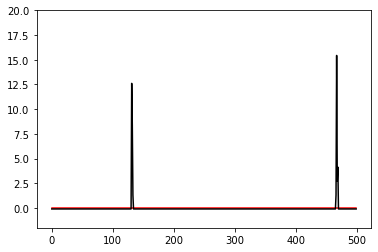

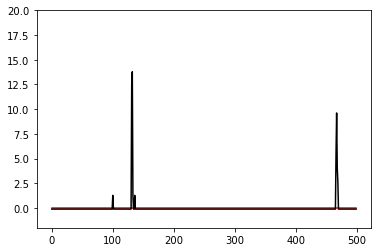

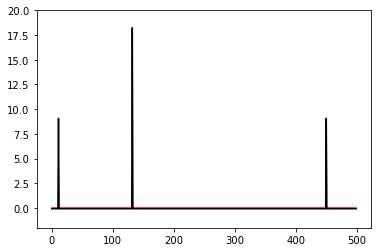

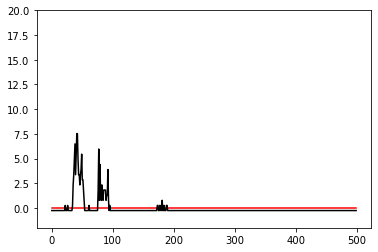

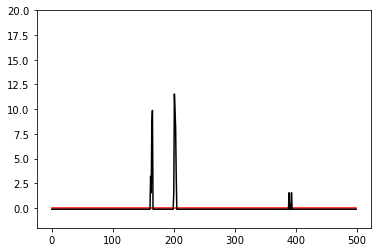

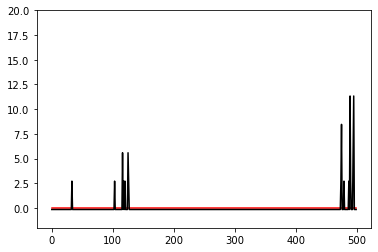

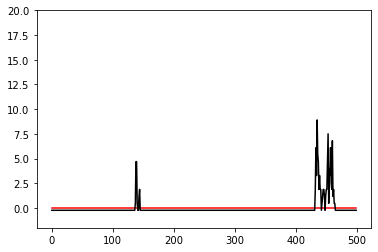

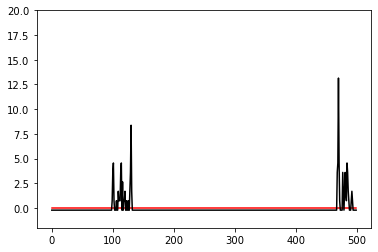

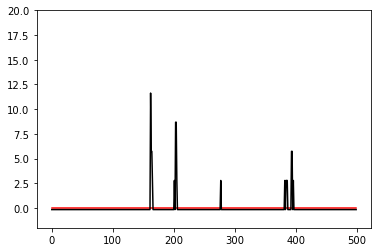

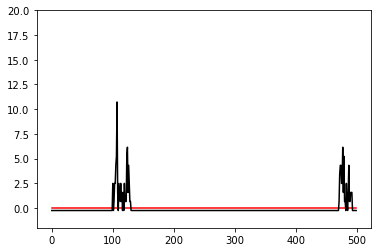

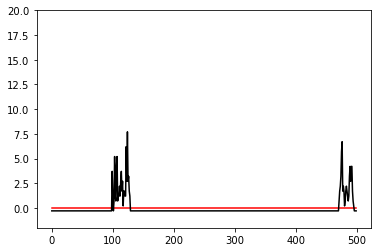

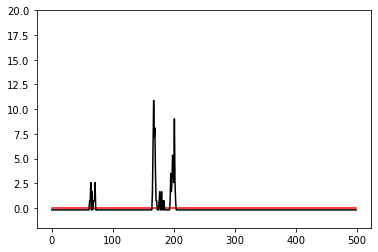

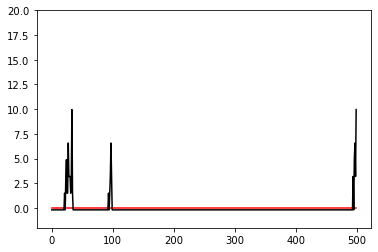

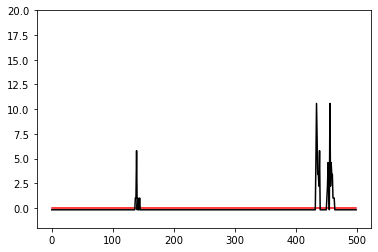

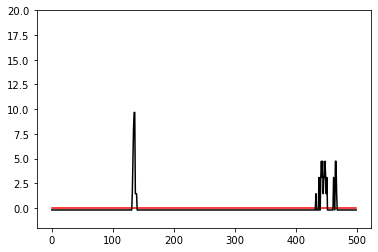

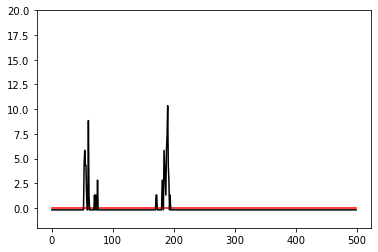

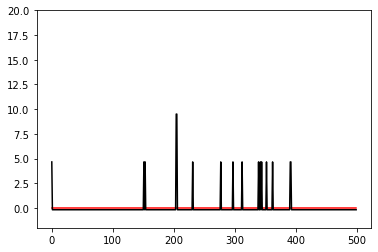

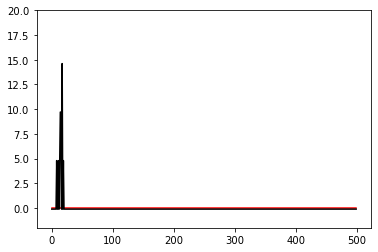

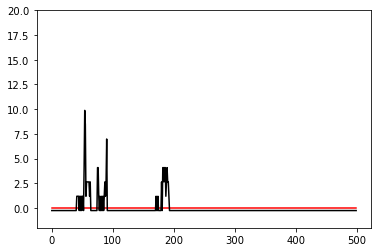

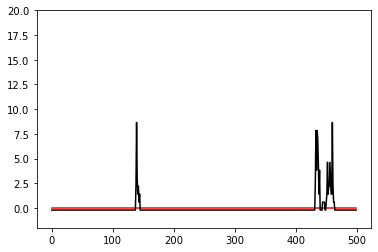

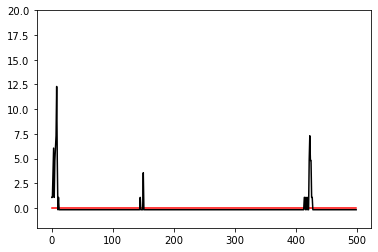

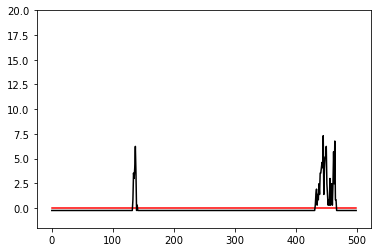

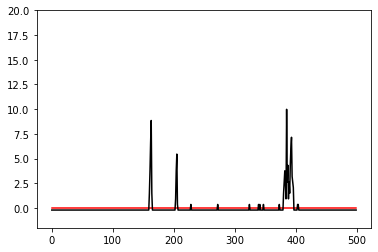

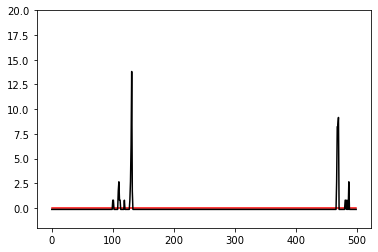

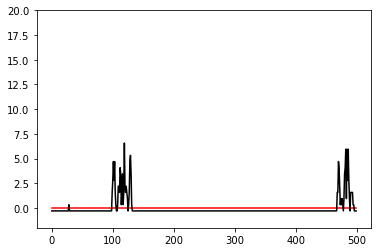

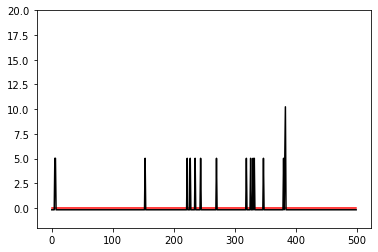

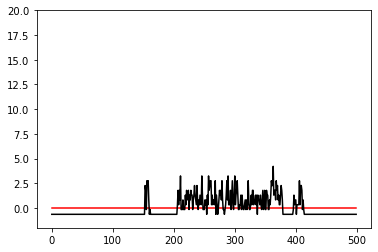

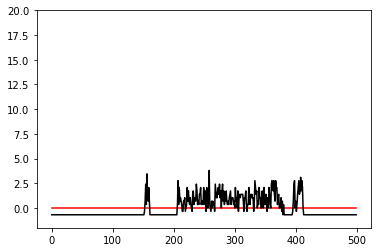

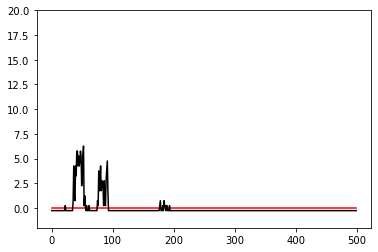

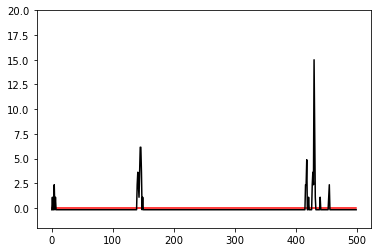

In [16]:
print(vae(x_batch_train).shape)
for i in range(neuron_num):
    plt.figure()
    plt.ylim(-2,20)
    plt.plot(vae(x_batch_train)[0,:,i],"r")
    plt.plot(output[0,:,i],'k')
    #plt.plot(x_batch_train[0,:,i],'b')

# Evaluate Quality of reconstruction 

(1, 500, 30)
(1, 500, 2)
(500, 2)
(500, 2)


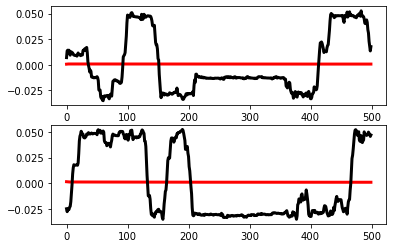

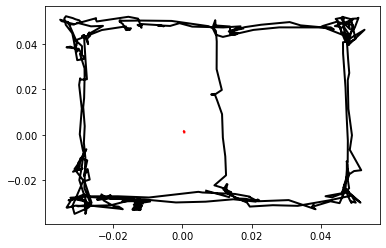

In [17]:
for x in batched_dataset.take(1):
    print(x.shape)
    qz_mean_est = vae.latent(x)
    print(qz_mean_est.shape)

qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
print(qz_est_norm[0].shape)

z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
print(z_true_norm.shape)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm[0]), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[0,:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[0,:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[0,:,0], qz_est_norm_R[0,:,1], lw=2, color = 'r')